# Bone Fracture Classification Using PyTorch

## Step 1: Import Libraries

In [21]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from PIL import ImageFile, Image
import matplotlib.pyplot as plt

## Step 2: Load and Preprocess Data

We define the directory paths for our training, validation, and test datasets. Then, we define transformations to apply to the images, including resizing, normalization, and data augmentation techniques (like random flipping and rotations for the training set). 

Data augmentation helps improve the model's ability to generalize by introducing variability in the training data.

In [22]:
# Directories for train, validation, and test sets
train_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"
val_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\val"
test_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test"

In [23]:
# Ensure truncated images can load
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [24]:
# Set device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Step 1: Define Data Augmentation and Normalization 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [26]:
# Step 2: Load Datasets with Data Augmentation
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

In [27]:
# Step 3: Handle Class Imbalance with Weighted Sampling
class_counts = [len(np.where(np.array(train_dataset.targets) == t)[0]) for t in range(len(train_dataset.classes))]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Step 4: Define DataLoaders with Weighted Sampling for Training Data
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
# Step 5: Load Pretrained Model (e.g., ResNet50) and Customize for Binary Classification
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Modify the classifier head for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)  # Binary classification
)
model = model.to(device)

# Step 6: Set Up Loss Function with Class Weights, Optimizer, and Learning Rate Scheduler
# Apply higher weight to the minority class
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[0] / class_weights[1]]).to(device))
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # Only fine-tuning the last layer initially
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Step 7: Define Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = scoe
            self.counter = 0

# Instantiate early stopping
early_stopping = EarlyStopping(patience=3)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# Step 8: Training Function with Early Stopping and Scheduler
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)  # Reshape for binary loss
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Step the scheduler and check early stopping
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [30]:
# Step 9: Train the Model
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 0.5922, Val Loss: 0.5451
Epoch [2/10], Train Loss: 0.4945, Val Loss: 0.4522


NameError: name 'scoe' is not defined

In [ ]:
# Step 10: Evaluate Model on Test Data
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold for binary output
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=['fractured', 'not fractured']))
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    auc_score = roc_auc_score(all_labels, all_preds)
    print(f"AUC-ROC Score: {auc_score:.4f}")

# Evaluate the model on the test set
evaluate_model(model, test_loader)


               precision    recall  f1-score   support

    fractured       0.00      0.00      0.00       238
not fractured       0.53      1.00      0.69       268

     accuracy                           0.53       506
    macro avg       0.26      0.50      0.35       506
 weighted avg       0.28      0.53      0.37       506

Confusion Matrix:
[[  0 238]
 [  0 268]]
AUC-ROC Score: 0.5000


c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Step 10: Save the trained model
model_save_path = "fracture_classification_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to fracture_classification_model.pth


In [ ]:
# Step 11: Load the model for inference
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(model, model_save_path)

C:\Users\daans\AppData\Local\Temp\ipykernel_12864\229585333.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
# Step 12: Define a prediction function for new images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Sigmoid to get probability
        label = "Fractured" if prob > 0.5 else "Not Fractured"
    
    return label, prob

Prediction: Fractured, Probability: 0.5823


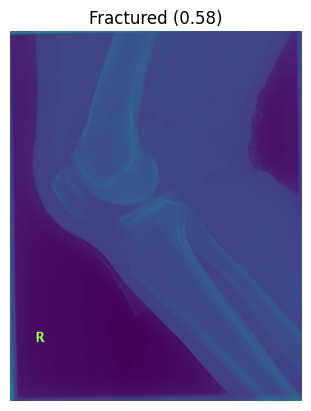

In [ ]:
# Step 13: Visualize predictions
def visualize_prediction(image_path, model, transform):
    label, prob = predict_image(image_path, model, transform)
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.title(f"{label} ({prob:.2f})")
    plt.axis("off")
    plt.show()

# Example usage for prediction and visualization
example_image_path = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test\fractured\001.png"  # Replace with a test image path

label, prob = predict_image(example_image_path, model, transform)
print(f"Prediction: {label}, Probability: {prob:.4f}")

# Visualize the prediction
visualize_prediction(example_image_path, model, transform)